0. Abstract

This notebook will examine behaviors of each visual explanation methods of deep learning model.
The model will train classifying to **_6 classes (buildings, forest, glacier, mountain, sea, street)_** for each images using this datasets.
The architecture of the model will be used **_pre-trained ResNet50_** and finetuning the task.
Visual explanation methods that will be examined are

\- **_Grad-CAM https://arxiv.org/abs/1610.02391_**  
\- **_Grad-CAM++ https://arxiv.org/abs/1710.11063_**  
\- **_Score-CAM https://arxiv.org/abs/1910.01279_**

1. Import libraries.

In [1]:
import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for i in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)
print(len(physical_devices), 'devices detect')

4 devices detect


2. Setting

\- Default size (W, H) of images  
\- The dictionary to exchange classes and labels  
\- The function to getting images / labels from directories

In [3]:
W = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
label_to_class = {'Digimon': 0,
 'Pokemon': 1}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='./dataset/train/', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    label_index=-1
    # 遞迴列出所有檔案的絕對路徑
    for root, dirs, files in os.walk(dir_name):
        for f in files:
            fullpath = os.path.join(root, f)
            img = load_img(fullpath, target_size=(W, H))
            img = img_to_array(img)
            Images.append(img)
            Classes.append(label_index)
        label_index=label_index+1

            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

3. Getting images / labels.

In [4]:
## get images / labels

Images, Classes = get_images()

Images.shape, Classes.shape

((1849, 112, 112, 3), (1849,))

4. Visualize some images / labels for each classes.

Pokemon 799 0.4321254732287723


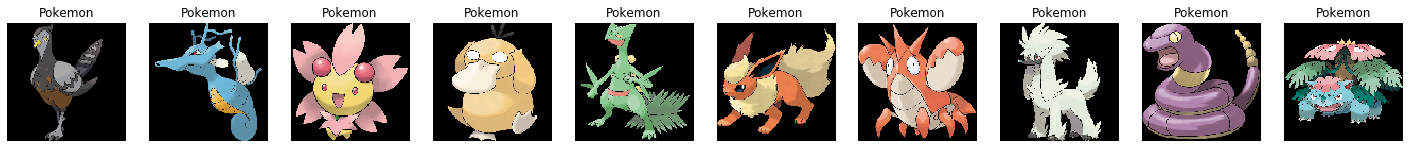

In [5]:
## visualize some images / labels

n_total_images = Images.shape[0]

for target_cls in [1]:

    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 10 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

5. Split datasets to train and test.

In [6]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), test_size=0.1, shuffle=True, random_state=44)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1664, 112, 112, 3), (1664,), (185, 112, 112, 3), (185,))

6. Convert images / labels to finetuning.

In [7]:
## to one-hot

y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((1664, 2), (185, 2))

In [8]:
## to image data generator

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0,                          # Randomly zoom image
    width_shift_range=0,                   # randomly shift images horizontally
    height_shift_range=0,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=True,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

7. Setting ResNet50 model for finetuning.

In [9]:
def build_model():
    """build model function"""
    
    # Resnet
    input_tensor = Input(shape=(W, H, 3)) # To change input shape
    resnet50 = ResNet50(
        include_top=False,                # To change output shape
        weights='imagenet',               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )
#     resnet50.trainable = True
    
    # fc layer
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D())               # Add GAP for cam
    top_model.add(Dense(n_classes, activation='softmax')) # Change output shape for this task
    
    # model
    model = Model(input=resnet50.input, output=top_model(resnet50.output))
    
    #  frozen weights
    for layer in model.layers[:-10]:
        layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable
        
    # compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
model = build_model()

In [11]:
model.layers[-2].name

'activation_49'

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 56, 56, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

8. Finetuning.

In [13]:
## finetuning

history = model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=64),
    epochs=5,
    steps_per_epoch=100,
    validation_data=datagen_test.flow(x_test, y_test, batch_size=1))

Epoch 1/5
100/100 [==============================] - 48s 476ms/step - loss: 0.0437 - accuracy: 0.9853 - val_loss: 0.0000e+00 - val_accuracy: 0.9892
Epoch 2/5
100/100 [==============================] - 24s 242ms/step - loss: 0.0073 - accuracy: 0.9972 - val_loss: 0.0000e+00 - val_accuracy: 0.9892
Epoch 3/5
100/100 [==============================] - 24s 241ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
100/100 [==============================] - 24s 239ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 0.9946
Epoch 5/5
100/100 [==============================] - 24s 237ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


9. Confirm the result of finetuning.

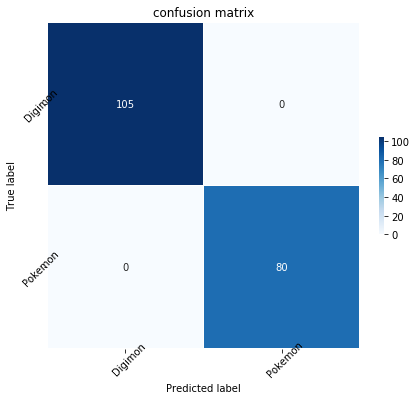

In [14]:
## plot confusion matrix

x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

10. Implement Grad-CAM, Grad-CAM++ and Score-CAM. First, implement the function to superimpose original image and heatmap of each cams.

In [15]:
def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img

In [16]:
def _plot(model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))
    
    img = cv2.resize(img, (540, 960))
    heatmap = cv2.resize(heatmap, (540, 960))
    superimposed_img = cv2.resize(superimposed_img, (540, 960))
    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.000001 0.999999
[1]


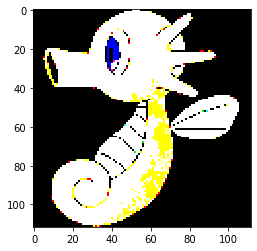

In [19]:
import matplotlib.pyplot as plt
import cv2

img_path= 'dataset/train/Pokemon/116.png'
alpha   = 0.3
# img = Image.open(img_path).convert('L')
# img = img.resize((128, 128))
# img = np.array(img).reshape(1,128,128,1)

img = cv2.imread(img_path)
img = cv2.resize(img, (112, 112)).reshape(112,112,3)[:,:,::-1]
img=preprocess_input(img)
# pred=ineference_model.predict(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(copy.deepcopy(x))
y_preds = model.predict(x)
print('%.6f'%y_preds[0][0],'%.6f'%y_preds[0][1])
y_preds = np.argmax(y_preds, axis=1)
plt.imshow(img)
print(y_preds)

Grad-CAM:


In [20]:
## Grad-CAM function

def grad_cam(model, x, layer_name):
    """Grad-CAM function"""
    
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam

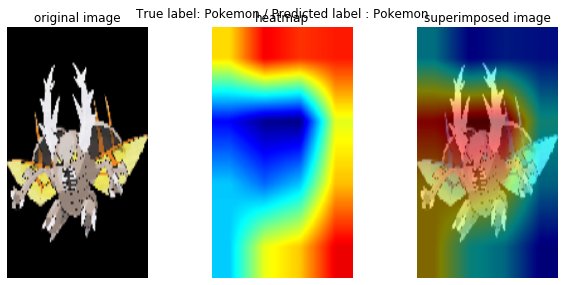

In [21]:
_plot(model=model, cam_func=grad_cam, img=Images[21], cls_true=Classes[21])

Grad-CAM++:

In [22]:
## Grad-CAM++ function

def grad_cam_plus_plus(model, x, layer_name):
    """Grad-CAM++ function"""
    
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom # 0


    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2)
    cam = np.maximum(cam, 0) # Passing through ReLU
    cam /= np.max(cam)       # scale 0 to 1.0  

    return cls, cam

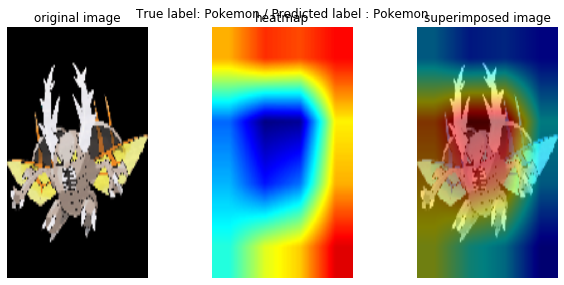

In [23]:
_plot(model=model, cam_func=grad_cam_plus_plus, img=Images[21], cls_true=Classes[21])

Score-CAM:


In [24]:
## Score-CAM function

def softmax(x):
    """softmax"""
    
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def score_cam(model, x, layer_name, max_N=-1):
    """Score-CAM function"""

    cls = np.argmax(model.predict(x))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(x)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0, :, :, k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:, :, :, max_N_indices]

    input_shape = model.layers[0].output_shape[1:]  # get input shape
    
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
        
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(x)
        for k in range(3):
            masked_input[0, :, :, k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:, cls]
    
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0, :, :, :], weights)
    cam = np.maximum(0, cam) # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0
    
    return cls, cam

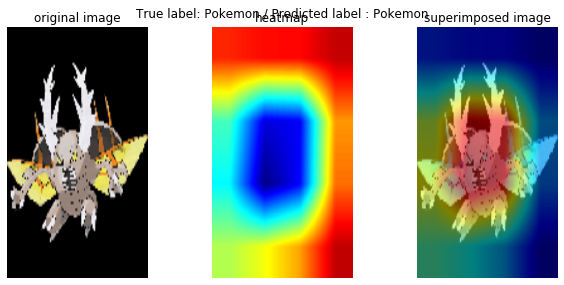

In [25]:
_plot(model=model, cam_func=score_cam, img=Images[21], cls_true=Classes[21])

11. Compare each visual methods. 

In [26]:
## compare Grad-CAM / Grad-CAM++ / Score-CAM

def _compare(model, layer_name, target_cls):
    """compare Grad-CAM / Grad-CAM++ / Score-CAM on target class images"""
    
    indices = np.where(Classes == target_cls)[0]
    label = class_to_label[target_cls]

    n_cols = 5 # # of sample plot

    fig, axs = plt.subplots(ncols=n_cols, nrows=4, figsize=(25, 9))

    for i in range(n_cols):
        img = Images[indices[i]]
        # for cam
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(copy.deepcopy(x))

        # original
        axs[0, i].imshow(np.uint8(img))
        axs[0, i].set_title(label)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        if i == 0:
            axs[0, i].set_ylabel('Original', rotation=0, ha='right')

        # Grad-CAM
        cls_pred, cam = grad_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam = superimpose(img, cam)
        axs[1, i].imshow(img_grad_cam)
        axs[1, i].set_title('pred: ' + class_to_label[cls_pred])
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        if i == 0:
            axs[1, i].set_ylabel('Grad-CAM', rotation=0, ha='right')

        # Grad-CAM++
        cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam_plus_plus = superimpose(img, cam)
        axs[2, i].imshow(img_grad_cam_plus_plus)
        axs[2, i].set_title('pred: ' + class_to_label[cls_pred])
        axs[2, i].set_xticks([])
        axs[2, i].set_yticks([])
        if i == 0:
            axs[2, i].set_ylabel('Grad-CAM++', rotation=0, ha='right')

        # Score-CAM
        cls_pred, cam = score_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_score_cam = superimpose(img, cam)
        axs[3, i].imshow(img_score_cam)
        axs[3, i].set_title('pred: ' + class_to_label[cls_pred])
        axs[3, i].set_xticks([])
        axs[3, i].set_yticks([])
        if i == 0:
            axs[3, i].set_ylabel('Score-CAM', rotation=0, ha='right')

    plt.show()

In [ ]:
_compare(model=model, layer_name=model.layers[-2].name, target_cls=1)